# How can we reduce the error in Zillow's Zestimate?

### Paddy Doran and Sean Oslin
November 12, 2019

# Project planning phase

### Project goals

1. Determine what factor(s) is driving the difference in Zestimate to sales price (i.e 'logerror').

2. Build an improved model to predict the logerror.

## Deliverables

## Acquisition, Prep, and Initial Exploration

### Data source
All data originated with the Zillow database.

### Python libraries used for analysis

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


### Python programming for this analysis imported from associated text documents¶

In [2]:
import env
df = pd.read_csv("zillow.csv")
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,12177905,2288172,NaN,NaN,NaN,3,4,NaN,8.0,3,...,108918.0,145143,2016,36225,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01
1,10887214,1970746,1.0,NaN,NaN,3,3,NaN,8.0,3,...,73681.0,119407,2016,45726,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01
2,12095076,781532,1.0,NaN,NaN,3,4,NaN,9.0,3,...,276684.0,773303,2016,496619,9516.26,NaN,NaN,6.037461e+13,-0.001011,2017-01-01
3,12069064,870991,NaN,NaN,NaN,1,2,NaN,5.0,1,...,18890.0,218552,2016,199662,2366.08,NaN,NaN,6.037302e+13,0.101723,2017-01-01
4,12790562,1246926,NaN,NaN,NaN,3,4,NaN,9.0,3,...,177527.0,220583,2016,43056,3104.19,NaN,NaN,6.037500e+13,-0.040966,2017-01-02


## Data preparation

#### Force 'head' to show all columns

In [3]:
pd.set_option('display.max_columns', None) 

#### Remove duplicate columns

In [4]:
def remove_dup_col(df):
    df = df.loc[:,~df.columns.duplicated()]
    return df

In [5]:
df = remove_dup_col(df)

#### Calculate the number and percent of missing values for each attribute

In [6]:
# def df2(df):
#     num_rows_missing = df.isna().sum()
#     pct_rows_missing = num_rows_missing/len(df)*100
#     df_sum = pd.DataFrame()
#     df_sum['num_rows_missing'] = num_rows_missing
#     df_sum['pct_rows_missing'] = pct_rows_missing
#     return df_sum

In [7]:
# df2(df)

#### Delete rows and columns with excessing missing values

In [8]:
def handle_missing_values(df, prop_required_column = .9, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df


def data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75):
    df.drop(columns = cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [9]:
df = data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75)

#### Drop unneeded columns

In [10]:
def drop_col(df):
        df = df.drop(columns = ['calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'propertycountylandusecode',
                            'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidzip', 
                            'censustractandblock', 'transactiondate', 'assessmentyear',
                            'roomcnt', 'regionidcounty'])
        return df

In [11]:
df = drop_col(df)

### Manage missing values

For land square feet, impute the missing values by creating a linear model where landtaxvaluedollarcnt is the x-variable and the output/y-variable is the estimated land square feet.

In [12]:
x = df['landtaxvaluedollarcnt']
y = df['lotsizesquarefeet']
ols_model = ols('lotsizesquarefeet ~ landtaxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['landtaxvaluedollarcnt']])

In [13]:
# Use y when we have y, if y is NaN, use yhat
df.lotsizesquarefeet = np.where(df.lotsizesquarefeet.isna(), df.yhat, df.lotsizesquarefeet)

In [14]:
def impute_values(df):
    sqfeet = df.calculatedfinishedsquarefeet.median()
    df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.fillna(sqfeet)
    
    structuretaxvalue = df.structuretaxvaluedollarcnt.median()
    df.structuretaxvaluedollarcnt = df.structuretaxvaluedollarcnt.fillna(structuretaxvalue)
    
    taxvalue = df.taxvaluedollarcnt.median()
    df.taxvaluedollarcnt = df.taxvaluedollarcnt.fillna(taxvalue)
    
    landtaxvalue = df.landtaxvaluedollarcnt.median()
    df.landtaxvaluedollarcnt = df.landtaxvaluedollarcnt.fillna(landtaxvalue)
    
    return df

In [15]:
x = df['taxvaluedollarcnt']
y = df['taxamount']
ols_model = ols('lotsizesquarefeet ~ taxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['taxvaluedollarcnt']])

In [16]:
# use y when we have y, if y is NaN, use yhat
df.taxamount = np.where(df.taxamount.isna(), df.yhat, df.taxamount)

#### Drop rows with no 'yearbuilt' date

In [17]:
df.fillna(value=pd.np.nan, inplace=True)

In [18]:
df = df.dropna()

In [19]:
def drop_col2(df): #Drop additional columns that are no longer of use. 
        df = df.drop(columns = ['taxamount', 'yhat'])
        return df

In [20]:
df = drop_col2(df)

#### Adjust data types

In [21]:
df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] =df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']].astype('int64')

#### Manage outliers

Upper outliers

In [22]:
def get_upper_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
                   for col in df.select_dtypes('number')}
    return df.assign(**outlier_cols)
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

add_upper_outlier_columns(df, k=4)

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,parcelid_outliers,id_outliers,bathroomcnt_outliers,bedroomcnt_outliers,buildingqualitytypeid_outliers,calculatedfinishedsquarefeet_outliers,fips_outliers,heatingorsystemtypeid_outliers,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,unitcnt_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,logerror_outliers
0,12177905,2288172,3,4,8.0,2376,6037,2.0,34245180,-118240722,13038,LCR110000*,1,1970,108918,145143,36225,-0.103410,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
1,10887214,1970746,3,3,8.0,1312,6037,2.0,34185120,-118414640,278581,LAR3,1,1964,73681,119407,45726,0.006940,0.0,0,0.0,0,0,0.0,0.0,0,0,0,206352.0,0.0,0,0.0,0.0,0.0,0.000000
2,12095076,781532,3,4,9.0,2962,6037,2.0,34145202,-118179824,63000,PSR2,1,1950,276684,773303,496619,-0.001011,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
4,12790562,1246926,3,4,9.0,3039,6037,2.0,33960230,-118006914,20028,WHRE20000*,1,1970,177527,220583,43056,-0.040966,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
5,11542646,1585097,3,2,8.0,1290,6037,2.0,33998800,-118416000,54048,LAR3,1,1980,151303,371361,220058,-0.036763,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
6,11104527,1639362,3,4,8.0,2540,6037,2.0,34434971,-118464390,10384,SCUR2,1,1999,271715,430108,158393,0.005963,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
7,12045625,1169121,3,3,8.0,1435,6037,2.0,34212400,-118238000,45171,GLR3*,1,1981,169727,259197,89470,-0.017167,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
8,11830315,571930,1,2,4.0,1146,6037,7.0,34024040,-118159090,4657,LCR2YY,1,1939,127960,273745,145785,-0.035085,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
9,12325145,2542130,2,3,6.0,1092,6037,2.0,33897676,-118169106,36005,PARM*,1,1979,140581,178646,38065,0.042463,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
11,11671335,1690166,3,2,9.0,2126,6037,2.0,34074859,-118563050,221601,LARD3,1,1983,276641,573247,296606,-0.000546,0.0,0,0.0,0,0,0.0,0.0,0,0,0,149372.0,0.0,0,0.0,0.0,0.0,0.000000


In [23]:
new_df = add_upper_outlier_columns(df, k = 4.0)
outlier_cols = [col for col in new_df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = new_df[col][new_df[col] > 0]
    print(data.describe())
    new_df = new_df[(new_df.logerror_outliers ==0) & (new_df.lotsizesquarefeet_outliers == 0)]
    new_df = new_df[(new_df.bathroomcnt_outliers == 0) & (new_df.calculatedfinishedsquarefeet_outliers == 0) & (new_df.calculatedfinishedsquarefeet_outliers == 0)]
    new_df = new_df[(new_df.structuretaxvaluedollarcnt_outliers == 0) & (new_df.taxvaluedollarcnt_outliers == 0) & (new_df.landtaxvaluedollarcnt_outliers == 0)]
    


~~~
parcelid_outliers
count    1.600000e+01
mean     1.497421e+08
std      4.776622e+03
min      1.497398e+08
25%      1.497404e+08
50%      1.497408e+08
75%      1.497419e+08
max      1.497597e+08
Name: parcelid_outliers, dtype: float64
~~~
id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: id_outliers, dtype: float64
~~~
bathroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bathroomcnt_outliers, dtype: float64
~~~
bedroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_outliers, dtype: float64
~~~
buildingqualitytypeid_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: buildingqualitytypeid_outliers, dtype: float64
~~~
calculatedfinishedsquarefeet_outliers
count    0.0
mean     NaN
std   

Lower outliers

In [24]:
def get_lower_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    lower_bound = q1- k * iqr
    return s.apply(lambda x: x if x < lower_bound else 0)

def add_lower_outlier_columns(df, k):
    outlier_cols = {col + '_outliers': get_lower_outliers(df[col], k)
                     for col in df.select_dtypes('number')}
    return df.assign(**outlier_cols)
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_lower_outliers(df3[col], k)

    return df

add_lower_outlier_columns(df, k=4)

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,parcelid_outliers,id_outliers,bathroomcnt_outliers,bedroomcnt_outliers,buildingqualitytypeid_outliers,calculatedfinishedsquarefeet_outliers,fips_outliers,heatingorsystemtypeid_outliers,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,unitcnt_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,logerror_outliers
0,12177905,2288172,3,4,8.0,2376,6037,2.0,34245180,-118240722,13038,LCR110000*,1,1970,108918,145143,36225,-0.103410,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
1,10887214,1970746,3,3,8.0,1312,6037,2.0,34185120,-118414640,278581,LAR3,1,1964,73681,119407,45726,0.006940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
2,12095076,781532,3,4,9.0,2962,6037,2.0,34145202,-118179824,63000,PSR2,1,1950,276684,773303,496619,-0.001011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
4,12790562,1246926,3,4,9.0,3039,6037,2.0,33960230,-118006914,20028,WHRE20000*,1,1970,177527,220583,43056,-0.040966,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
5,11542646,1585097,3,2,8.0,1290,6037,2.0,33998800,-118416000,54048,LAR3,1,1980,151303,371361,220058,-0.036763,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
6,11104527,1639362,3,4,8.0,2540,6037,2.0,34434971,-118464390,10384,SCUR2,1,1999,271715,430108,158393,0.005963,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
7,12045625,1169121,3,3,8.0,1435,6037,2.0,34212400,-118238000,45171,GLR3*,1,1981,169727,259197,89470,-0.017167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
8,11830315,571930,1,2,4.0,1146,6037,7.0,34024040,-118159090,4657,LCR2YY,1,1939,127960,273745,145785,-0.035085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
9,12325145,2542130,2,3,6.0,1092,6037,2.0,33897676,-118169106,36005,PARM*,1,1979,140581,178646,38065,0.042463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
11,11671335,1690166,3,2,9.0,2126,6037,2.0,34074859,-118563050,221601,LARD3,1,1983,276641,573247,296606,-0.000546,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000


#### Drop outlier columns

In [25]:
def drop_col(new_df):
    new_df = new_df.drop(columns = [
           'parcelid_outliers', 'id_outliers', 'bathroomcnt_outliers',
           'bedroomcnt_outliers', 'buildingqualitytypeid_outliers',
           'calculatedfinishedsquarefeet_outliers', 'fips_outliers',
           'heatingorsystemtypeid_outliers', 'latitude_outliers',
           'longitude_outliers', 'lotsizesquarefeet_outliers', 'unitcnt_outliers',
           'yearbuilt_outliers', 'structuretaxvaluedollarcnt_outliers',
           'taxvaluedollarcnt_outliers', 'landtaxvaluedollarcnt_outliers',
           'logerror_outliers', 'propertyzoningdesc', 'buildingqualitytypeid', 'heatingorsystemtypeid'])
    return new_df

In [26]:
new_df = drop_col(new_df)

In [27]:
train, test = train_test_split(new_df, test_size=.30, random_state = 123)

#### Encode the bathroom and bedroom counts

In [28]:
def one_hot_encode(train, test, col_name):

    encoded_values = sorted(list(train[col_name].unique()))

    train_array = np.array(train[col_name]).reshape(len(train[col_name]),1)
    test_array = np.array(test[col_name]).reshape(len(test[col_name]),1)

    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=encoded_values, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                            columns=encoded_values, index=test.index)
    test = test.join(test_encoded)

    return train, test

In [29]:
train, test = one_hot_encode(train, test, col_name = 'bathroomcnt')

In [30]:
train.rename(columns={1:'1bath', 2:'2bath', 3:'3bath', 4: '4bath', 5:'5bath', 6:'6bath', 7: '7bath'}, inplace=True)
test.rename(columns={1:'1bath', 2:'2bath', 3:'3bath', 4: '4bath', 5:'5bath', 6:'6bath', 7: '7bath'}, inplace=True)

In [31]:
train, test = one_hot_encode(train, test, col_name = 'bedroomcnt')

In [32]:
train.rename(columns={1:'1bed', 2:'2bed', 3:'3bed', 4: '4bed', 5:'5bed', 6:'6bed', 7: '7bed', 8: '8bed', 9:'9bed'}, inplace=True)
test.rename(columns={1:'1bed', 2:'2bed', 3:'3bed', 4: '4bed', 5:'5bed', 6:'6bed', 7: '7bed', 8: '8bed', 9:'9bed'}, inplace=True)

In [33]:
train.reset_index(drop = True, inplace = True)
test.reset_index(inplace = True)

In [34]:
scaler = StandardScaler()

train_scaled = train.copy()
test_scaled = test.copy()

train_scaled = train_scaled[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
test_scaled = test_scaled[['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
scaler.fit(train_scaled)
scaler.fit(test_scaled)
train_scaled = scaler.transform(train_scaled)
test_scaled = scaler.transform(test_scaled)                   

In [35]:
train_scaled = pd.DataFrame(train_scaled)
train_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']

In [36]:
# train_scaled = pd.DataFrame(train_scaled)
# train_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']
# test_scaled = pd.DataFrame(test_scaled)
# test_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']

In [37]:
train[['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]= train_scaled[['calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt', 'lotsizesquarefeet','taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
train.head()

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
0,10745756,135548,4,4,2.446433,6037,34165692,-118770919,2.727203,1,1986,-0.214909,1.736769,0.966601,-0.061629,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,12692106,2961206,2,3,-0.036957,6037,33784829,-118314531,-0.838683,1,1949,-0.183526,-0.162260,0.192868,0.015970,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11839030,1019191,2,4,-0.038388,6037,34042958,-118142629,-0.272130,1,1956,-0.457953,0.765742,1.141300,-0.133100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,11280682,853535,2,3,-0.348991,6037,34685575,-118177612,-0.378959,1,1972,-0.205549,-0.804102,-0.876098,-0.043454,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12381829,484421,1,2,-1.154840,6037,33983552,-118118690,-1.011569,1,1942,-0.356803,-0.594522,-0.293050,0.016932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Create dependent variable 'logerror'

In [38]:
# X_train = train.drop(columns ='logerror')
# y_train = train[['logerror']]
# X_test = test.drop(columns ='logerror')
# y_test = test[['logerror']]

In [39]:
# X_train.info()

#### Create clusters

   k           sse
0  1  43738.037848
1  2  22164.072712
2  3  16033.746843
3  4  12201.645569
4  5   8935.899676
5  6   7520.628117
6  7   5566.666269
7  8   3949.735016
8  9   3116.453341


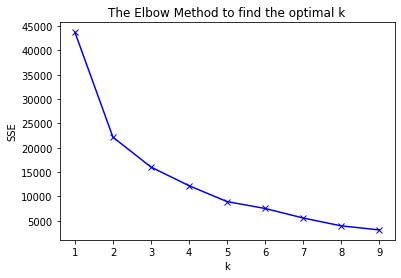

In [40]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(train[['bathroomcnt', 'bedroomcnt']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [41]:
def target_cluster(train):
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(train[['bathroomcnt', 'bedroomcnt']])
    train['cluster'] = kmeans.predict(train[['bathroomcnt', 'bedroomcnt']])
    return train


In [42]:
train1 = target_cluster(train)

In [43]:
train1.groupby(train1['cluster']).mean().sort_values('logerror')

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1.192178e+07,1.486349e+06,1.452668,1.871749,-0.787652,6037.0,3.404596e+07,-1.182663e+08,-0.416132,1.0,1954.828206,0.200921,-0.240442,-0.115111,-0.007449,0.547332,0.452668,0.000000,0.000000,0.000000,0.000000,0.000000,0.128251,0.871749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,1.193208e+07,1.513316e+06,1.751248,3.012537,-0.322757,6037.0,3.410769e+07,-1.182133e+08,-0.386251,1.0,1955.462887,-0.304973,-0.261317,-0.157118,-0.002264,0.248752,0.751248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.987463,0.012537,0.000000,0.000000,0.000000,0.000000,0.00000
0,1.184416e+07,1.523123e+06,3.056782,2.740144,0.336166,6037.0,3.412205e+07,-1.182893e+08,0.558598,1.0,1980.443094,0.458929,0.379956,0.229913,0.001471,0.000000,0.000000,0.943218,0.056782,0.000000,0.000000,0.000000,0.002232,0.255393,0.742375,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,1.188571e+07,1.506950e+06,2.570147,4.156879,0.687308,6037.0,3.417178e+07,-1.182422e+08,0.298318,1.0,1969.221865,-0.189433,0.098621,-0.014685,0.005647,0.002369,0.425114,0.572517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.855475,0.132510,0.011677,0.000338,0.000000,0.00000
3,1.176835e+07,1.452746e+06,4.295419,4.616904,2.410986,6037.0,3.414695e+07,-1.183456e+08,1.901982,1.0,1976.537915,0.221607,1.291976,0.780532,0.015360,0.000000,0.000000,0.012638,0.716430,0.237757,0.029226,0.003949,0.000000,0.000000,0.008689,0.506319,0.375987,0.082938,0.021327,0.003949,0.00079


In [44]:
train1.cluster.value_counts()

1    9013
2    6729
4    5909
0    4033
3    1266
Name: cluster, dtype: int64

In [45]:
train1.groupby('cluster').mean()

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.184416e+07,1.523123e+06,3.056782,2.740144,0.336166,6037.0,3.412205e+07,-1.182893e+08,0.558598,1.0,1980.443094,0.458929,0.379956,0.229913,0.001471,0.000000,0.000000,0.943218,0.056782,0.000000,0.000000,0.000000,0.002232,0.255393,0.742375,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,1.193208e+07,1.513316e+06,1.751248,3.012537,-0.322757,6037.0,3.410769e+07,-1.182133e+08,-0.386251,1.0,1955.462887,-0.304973,-0.261317,-0.157118,-0.002264,0.248752,0.751248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.987463,0.012537,0.000000,0.000000,0.000000,0.000000,0.00000
2,1.192178e+07,1.486349e+06,1.452668,1.871749,-0.787652,6037.0,3.404596e+07,-1.182663e+08,-0.416132,1.0,1954.828206,0.200921,-0.240442,-0.115111,-0.007449,0.547332,0.452668,0.000000,0.000000,0.000000,0.000000,0.000000,0.128251,0.871749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,1.176835e+07,1.452746e+06,4.295419,4.616904,2.410986,6037.0,3.414695e+07,-1.183456e+08,1.901982,1.0,1976.537915,0.221607,1.291976,0.780532,0.015360,0.000000,0.000000,0.012638,0.716430,0.237757,0.029226,0.003949,0.000000,0.000000,0.008689,0.506319,0.375987,0.082938,0.021327,0.003949,0.00079
4,1.188571e+07,1.506950e+06,2.570147,4.156879,0.687308,6037.0,3.417178e+07,-1.182422e+08,0.298318,1.0,1969.221865,-0.189433,0.098621,-0.014685,0.005647,0.002369,0.425114,0.572517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.855475,0.132510,0.011677,0.000338,0.000000,0.00000


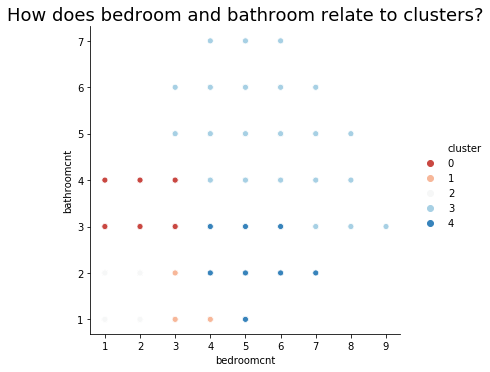

In [46]:
sns.relplot(data=train1, x='bedroomcnt', y='bathroomcnt', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does bedroom and bathroom relate to clusters?', fontsize = 18)
plt.show()

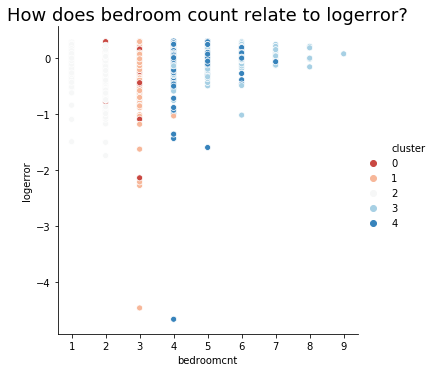

In [47]:
sns.relplot(data=train1, x='bedroomcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does bedroom count relate to logerror?', fontsize = 18)
plt.show()

In [93]:
#stats.f_oneway(data_group1, data_group2, data_group3, data_groupN)

cluster_1 =train1[train1.cluster == 1]
cluster_1.head()
cluster_2 =train1[train1.cluster == 2]
cluster_2.head()
cluster_3 =train1[train1.cluster == 3]
cluster_3.head()
cluster_4 =train1[train1.cluster == 4]
cluster_4.head()
cluster_5 =train1[train1.cluster == 5]
cluster_5.head()

compare variance
check normality

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed,cluster,cluster_df2


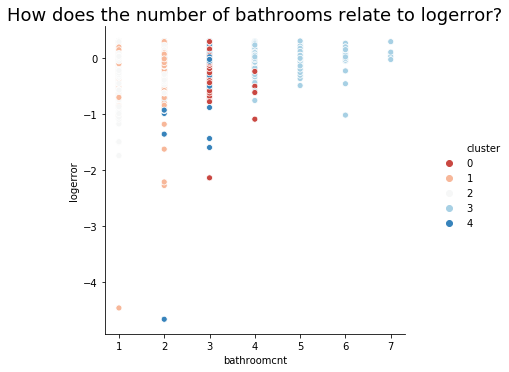

In [49]:
sns.relplot(data=train1, x='bathroomcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does the number of bathrooms relate to logerror?', fontsize = 18)
plt.show()

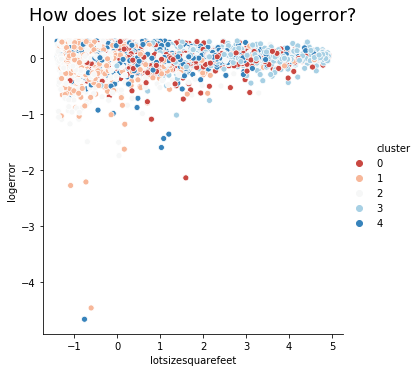

In [50]:
sns.relplot(data=train1, x='lotsizesquarefeet', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does lot size relate to logerror?', fontsize = 18)
plt.show()

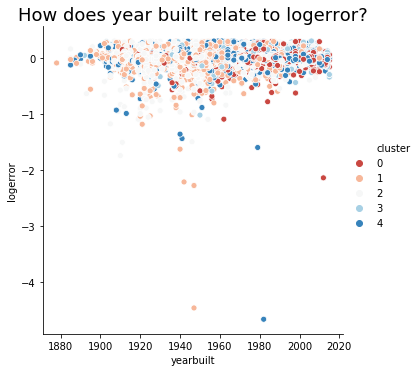

In [51]:
sns.relplot(data=train1, x='yearbuilt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does year built relate to logerror?', fontsize = 18)
plt.show()

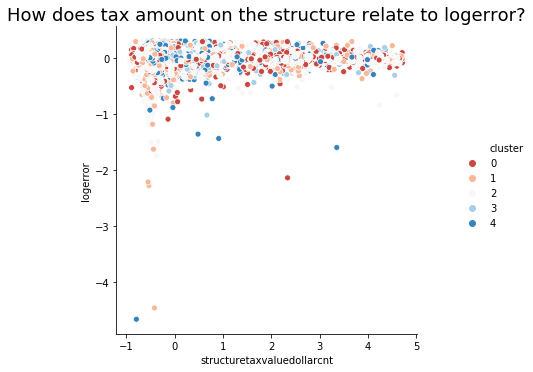

In [52]:
sns.relplot(data=train1, x='structuretaxvaluedollarcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does tax amount on the structure relate to logerror?', fontsize = 18)
plt.show()

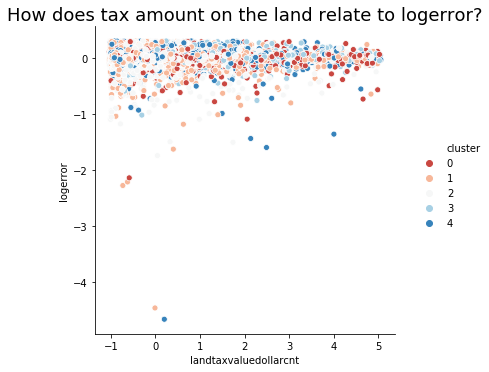

In [53]:
sns.relplot(data=train1, x='landtaxvaluedollarcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does tax amount on the land relate to logerror?', fontsize = 18)
plt.show()

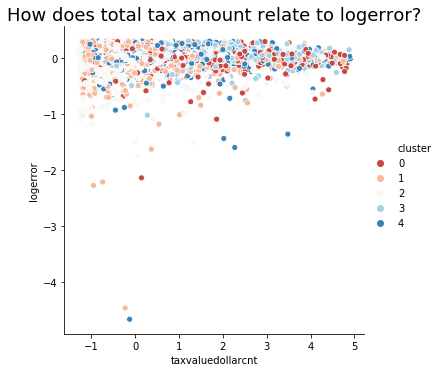

In [54]:
sns.relplot(data=train, x='taxvaluedollarcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does total tax amount relate to logerror?', fontsize = 18)
plt.show()

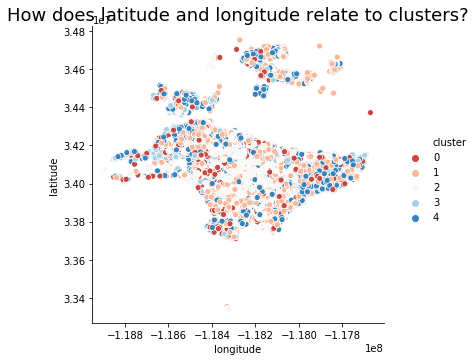

In [55]:
sns.relplot(data=train1, x='longitude', y='latitude', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does latitude and longitude relate to clusters?', fontsize = 18)
plt.show()

   k           sse
0  1  2.638030e+15
1  2  1.532507e+15
2  3  9.538659e+14
3  4  5.942574e+14
4  5  4.363503e+14
5  6  3.547538e+14
6  7  2.867998e+14
7  8  2.413186e+14
8  9  2.093329e+14


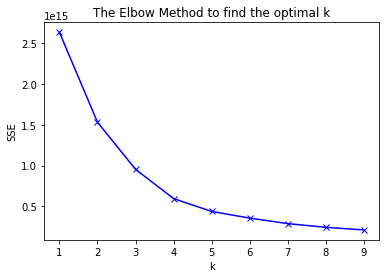

In [56]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(train[['latitude', 'longitude']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [57]:
def target_cluster(train):
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(train[['latitude', 'longitude']])
    train['cluster'] = kmeans.predict(train[['latitude', 'longitude']])
    return train

In [90]:
train2 = target_cluster(train)

In [59]:
train2.groupby(train2['cluster']).mean().sort_values('taxvaluedollarcnt')

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,1.132419e+07,1.508189e+06,2.367110,3.462860,0.293553,6037.0,3.462946e+07,-1.181250e+08,-0.100432,1.0,1986.195792,-0.066187,-0.675232,-0.841315,-0.002267,0.068699,0.536711,0.357664,0.032632,0.004294,0.000000,0.000000,0.003864,0.049377,0.519536,0.349506,0.063976,0.012452,0.001288,0.000000,0.000000
2,1.263848e+07,1.515015e+06,2.131971,3.102744,-0.032050,6037.0,3.406784e+07,-1.179850e+08,-0.105641,1.0,1960.502833,-0.061792,-0.115036,-0.100396,0.004753,0.222040,0.477781,0.257680,0.032508,0.008947,0.000746,0.000298,0.016105,0.210707,0.486132,0.237996,0.041455,0.005816,0.001640,0.000149,0.000000
0,1.222463e+07,1.505233e+06,1.915152,2.819232,-0.257325,6037.0,3.389479e+07,-1.182551e+08,-0.215916,1.0,1955.584547,-0.145848,-0.082362,-0.003847,-0.004283,0.348177,0.429655,0.186184,0.031171,0.004573,0.000120,0.000120,0.044650,0.325310,0.436755,0.159105,0.028884,0.004453,0.000602,0.000241,0.000000
1,1.123903e+07,1.493692e+06,2.372371,3.009473,0.200875,6037.0,3.420055e+07,-1.184621e+08,0.299651,1.0,1965.672288,0.145296,0.292106,0.239701,-0.000290,0.145430,0.448157,0.322194,0.060691,0.020092,0.003227,0.000208,0.039975,0.277431,0.396211,0.216219,0.061628,0.007183,0.001041,0.000208,0.000104


In [60]:
train2.cluster.value_counts()

1    9606
0    8309
2    6706
3    2329
Name: cluster, dtype: int64

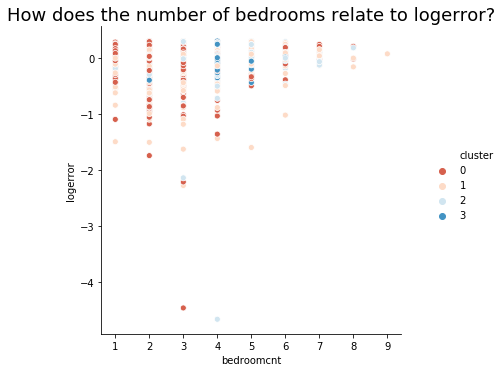

In [61]:
sns.relplot(data=train2, x='bedroomcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))
plt.title('How does the number of bedrooms relate to logerror?', fontsize = 18)
plt.show()

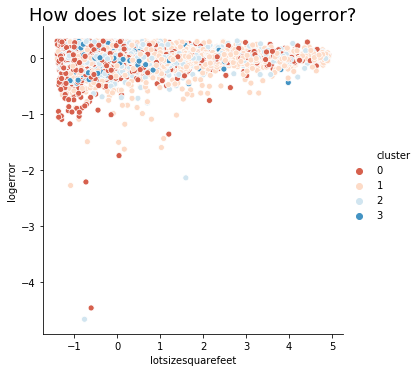

In [62]:
sns.relplot(data=train2, x='lotsizesquarefeet', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))
plt.title('How does lot size relate to logerror?', fontsize = 18)
plt.show()

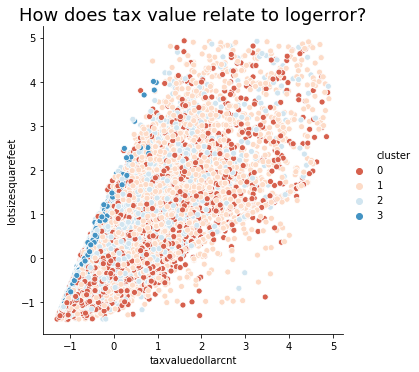

In [63]:
sns.relplot(data=train2, x='taxvaluedollarcnt', y='lotsizesquarefeet', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))

plt.title('How does tax value relate to logerror?', fontsize = 18)
plt.show()

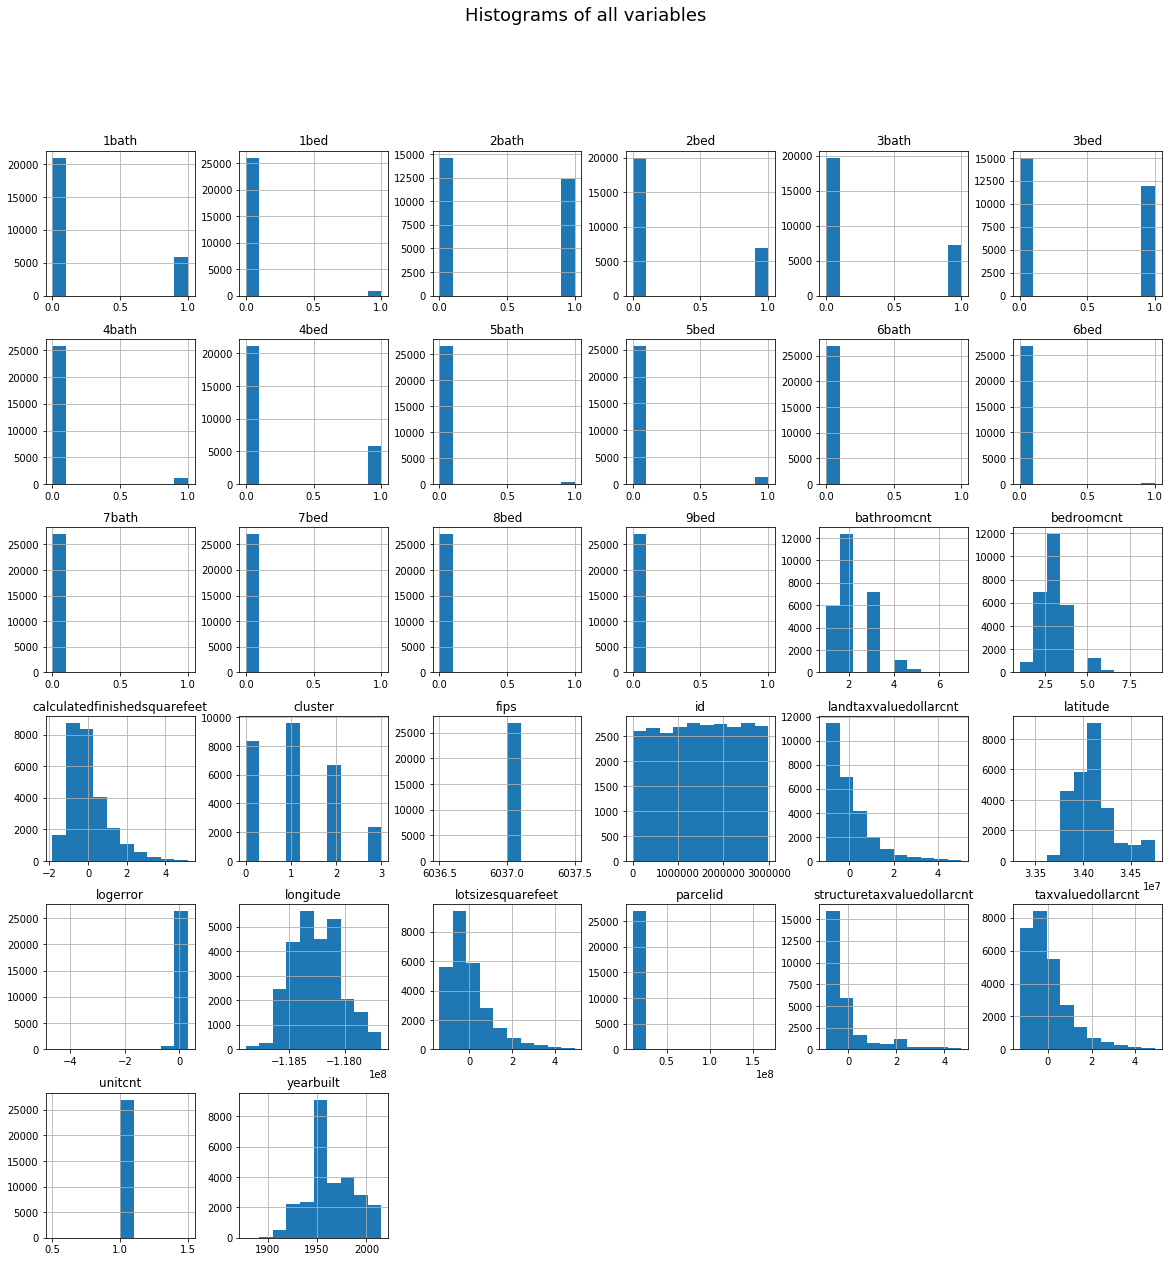

In [64]:
train.hist(figsize=(20, 20), bins=10, log=False)
plt.suptitle('Histograms of all variables', fontsize = 18)
plt.show()

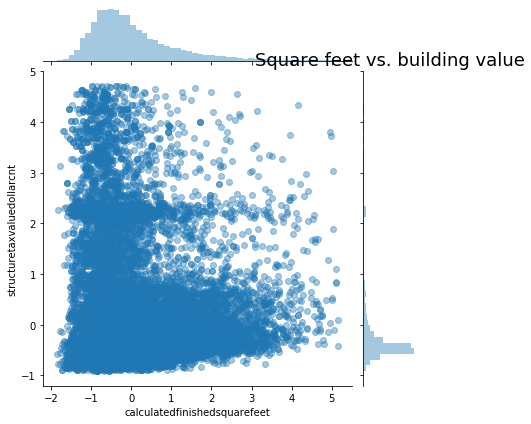

In [65]:
sns.jointplot(data=train, x='calculatedfinishedsquarefeet', y='structuretaxvaluedollarcnt', alpha = .4)
plt.title('Square feet vs. building value', fontsize = 18)
plt.show()

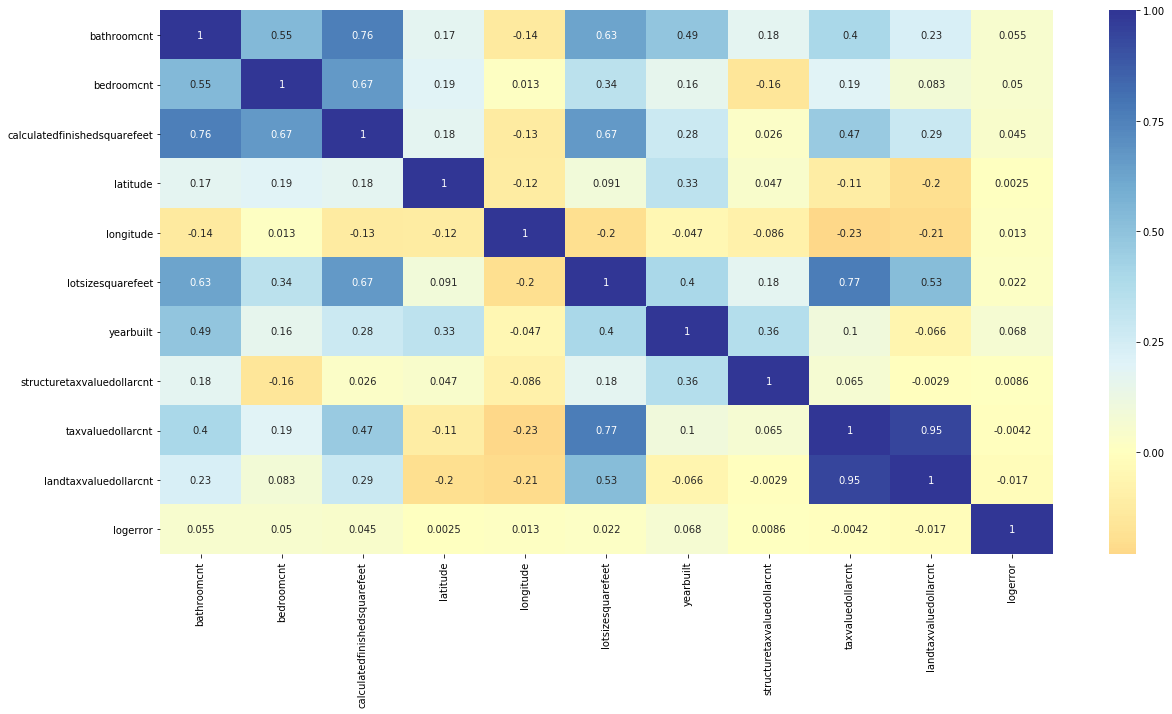

In [66]:
corr1 = train[['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet','latitude', 'longitude', 'lotsizesquarefeet','yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'logerror']]
plt.figure(figsize=(20,10))
sns.heatmap(corr1.corr(), cmap='RdYlBu', annot=True, center=0)
plt.show()

Cluster Independent Variables You should also perform some clustering based on a number of independent variables. Create and evaluate several clustering models based on subsets of the independent variables. Here are some ideas:
Location, that is, latitude and longitude Size (finished square feet) Location and size Be sure to use these new clusters in exploring your data, and interpret what these clusters tell you.

In [67]:
train.columns

Index(['parcelid', 'id', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude',
       'lotsizesquarefeet', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'logerror', '1bath', '2bath', '3bath', '4bath',
       '5bath', '6bath', '7bath', '1bed', '2bed', '3bed', '4bed', '5bed',
       '6bed', '7bed', '8bed', '9bed', 'cluster'],
      dtype='object')

In [68]:
from sklearn.cluster import KMeans

C1 = train[['latitude', 'longitude', 'lotsizesquarefeet']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(C1)

print(kmeans.cluster_centers_)



[[ 3.38939534e+07 -1.18254797e+08 -2.17203304e-01]
 [ 3.42000976e+07 -1.18461619e+08  2.99568207e-01]
 [ 3.46294603e+07 -1.18124955e+08 -1.00432174e-01]
 [ 3.40679166e+07 -1.17985084e+08 -1.06625268e-01]]


In [69]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=C1.columns)
centers
C1Label = pd.Series(kmeans.labels_)
C1Label.value_counts()

1    9633
0    8291
3    6697
2    2329
dtype: int64

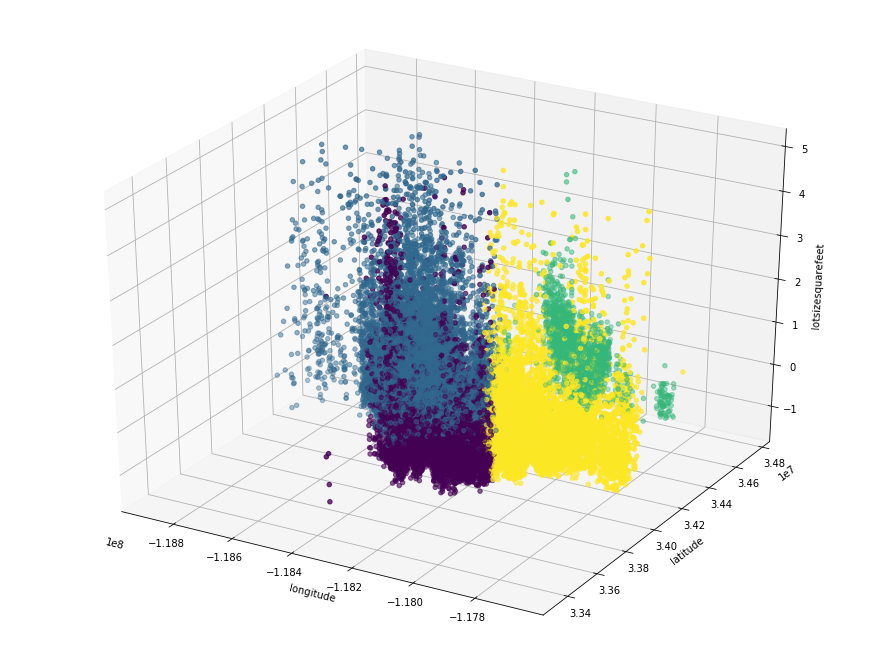

In [70]:
%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(C1.longitude, C1.latitude, C1.lotsizesquarefeet, c=kmeans.labels_)
ax.scatter(centers.longitude, centers.latitude, centers.lotsizesquarefeet, c='pink', s=100, alpha=.9)
ax.set(xlabel='longitude', ylabel='latitude', zlabel='lotsizesquarefeet')
plt.show()

In [71]:
C2 = train[['latitude', 'longitude', 'structuretaxvaluedollarcnt']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(C2)
centers2 = pd.DataFrame(kmeans.cluster_centers_, columns=C2.columns)
print(centers2)
C2Label = pd.Series(kmeans.labels_)
C2Label.value_counts()
print(kmeans.cluster_centers_)

       latitude     longitude  structuretaxvaluedollarcnt
0  3.420047e+07 -1.184620e+08                    0.144799
1  3.406777e+07 -1.179853e+08                   -0.062402
2  3.389442e+07 -1.182553e+08                   -0.145145
3  3.462946e+07 -1.181250e+08                   -0.066187
[[ 3.42004705e+07 -1.18462006e+08  1.44799326e-01]
 [ 3.40677713e+07 -1.17985307e+08 -6.24017084e-02]
 [ 3.38944209e+07 -1.18255256e+08 -1.45145307e-01]
 [ 3.46294603e+07 -1.18124955e+08 -6.61872956e-02]]


In [72]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=C2.columns)
centers
C2Label = pd.Series(kmeans.labels_)
C2Label.value_counts()

0    9611
2    8307
1    6703
3    2329
dtype: int64

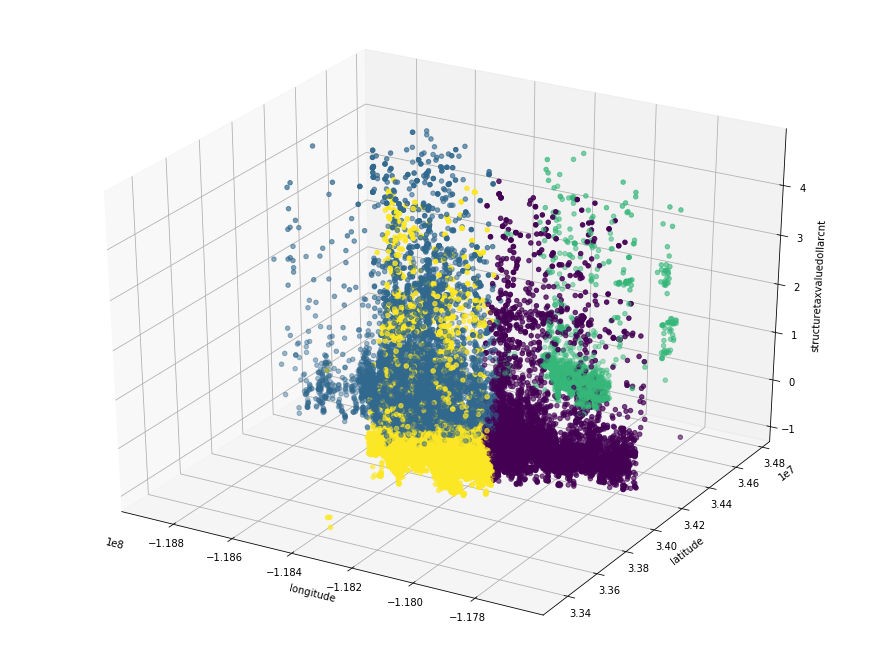

In [88]:
%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(C2.longitude, C2.latitude, C2.structuretaxvaluedollarcnt, c=kmeans.labels_)
# ax.scatter(centers.longitude, centers.latitude, centers.structuretaxvaluedollarcnt, c='pink', s=100, alpha=.9)
ax.set(xlabel='longitude', ylabel='latitude', zlabel='structuretaxvaluedollarcnt')
plt.show()

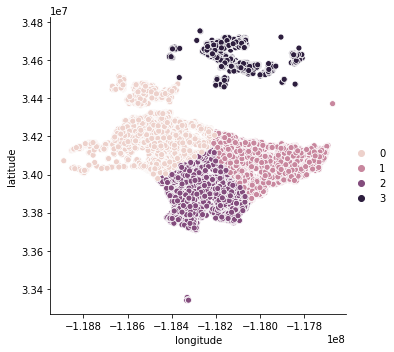

In [74]:
sns.relplot(data=C2, hue=kmeans.labels_, x='longitude', y='latitude')
plt.show()

   k           sse
0  1  2.638030e+15
1  2  1.532504e+15
2  3  9.538659e+14
3  4  5.942574e+14
4  5  4.363497e+14
5  6  3.547522e+14
6  7  2.867998e+14
7  8  2.413186e+14
8  9  2.093192e+14


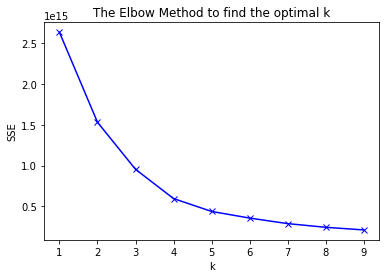

In [75]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(train[['longitude', 'latitude', 'calculatedfinishedsquarefeet']])
    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)
print(pd.DataFrame(dict(k=ks, sse=sse)))
plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()



In [76]:
C3 = train[['latitude', 'longitude', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(C3)
centers3 = pd.DataFrame(kmeans.cluster_centers_, columns=C3.columns)
print(centers3)
C3Label = pd.Series(kmeans.labels_)
C3Label.value_counts()
print(kmeans.cluster_centers_)

       latitude     longitude  calculatedfinishedsquarefeet
0  3.406799e+07 -1.179850e+08                     -0.033602
1  3.419992e+07 -1.184614e+08                      0.199136
2  3.462946e+07 -1.181250e+08                      0.293553
3  3.389371e+07 -1.182546e+08                     -0.256589
[[ 3.40679902e+07 -1.17984969e+08 -3.36021949e-02]
 [ 3.41999191e+07 -1.18461411e+08  1.99136087e-01]
 [ 3.46294603e+07 -1.18124955e+08  2.93553334e-01]
 [ 3.38937100e+07 -1.18254587e+08 -2.56588518e-01]]


In [77]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=C3.columns)
centers
C3Label = pd.Series(kmeans.labels_)
C3Label.value_counts()

1    9640
3    8287
0    6694
2    2329
dtype: int64

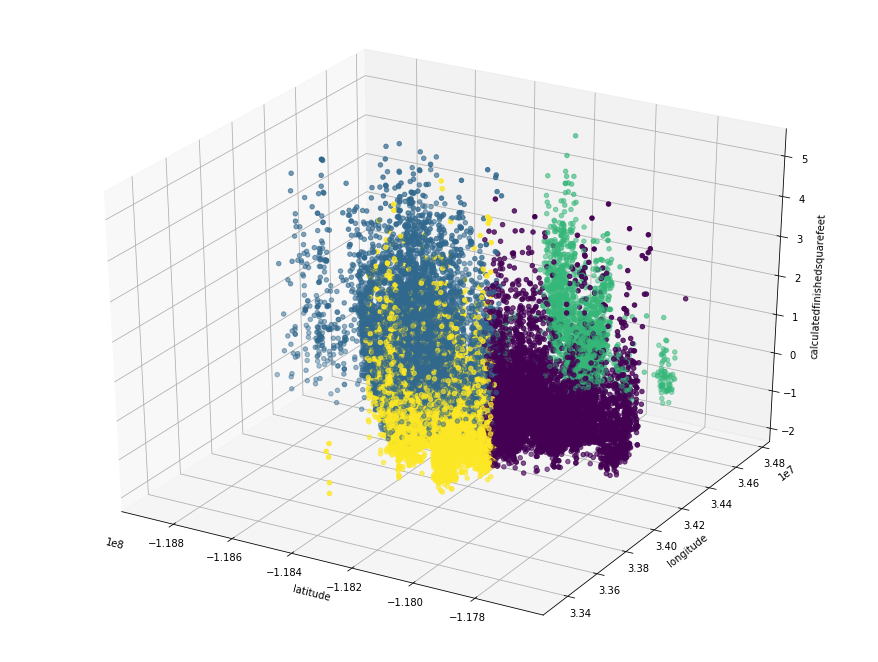

In [89]:
%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(C3.longitude, C3.latitude, C3.calculatedfinishedsquarefeet, c=kmeans.labels_)
ax.scatter(centers.longitude, centers.latitude, centers.calculatedfinishedsquarefeet, c='pink', s=100, alpha=.9)
ax.set(xlabel='latitude', ylabel='longitude', zlabel='calculatedfinishedsquarefeet')
plt.show()

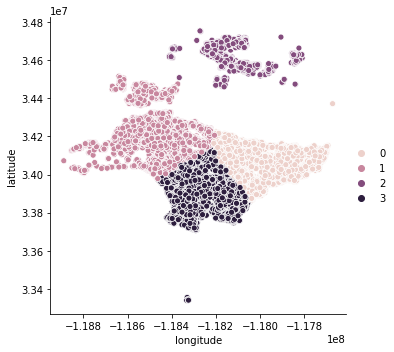

In [79]:
sns.relplot(data=C3, hue=kmeans.labels_, x='longitude', y='latitude')

In [80]:
def target_cluster(cluster_df):
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(cluster_df)
    cluster_df['cluster_df'] = kmeans.predict(cluster_df)
    new_train = train.merge(cluster_df,left_index=True,right_index=True)
    return new_train

In [81]:
ntrain = target_cluster(C1)
ntrain

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude_x,longitude_x,lotsizesquarefeet_x,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed,cluster,latitude_y,longitude_y,lotsizesquarefeet_y,cluster_df
0,10745756,135548,4,4,2.446433,6037,34165692,-118770919,2.727203,1,1986,-0.214909,1.736769,0.966601,-0.061629,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,34165692,-118770919,2.727203,0
1,12692106,2961206,2,3,-0.036957,6037,33784829,-118314531,-0.838683,1,1949,-0.183526,-0.162260,0.192868,0.015970,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,33784829,-118314531,-0.838683,1
2,11839030,1019191,2,4,-0.038388,6037,34042958,-118142629,-0.272130,1,1956,-0.457953,0.765742,1.141300,-0.133100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,34042958,-118142629,-0.272130,1
3,11280682,853535,2,3,-0.348991,6037,34685575,-118177612,-0.378959,1,1972,-0.205549,-0.804102,-0.876098,-0.043454,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,34685575,-118177612,-0.378959,2
4,12381829,484421,1,2,-1.154840,6037,33983552,-118118690,-1.011569,1,1942,-0.356803,-0.594522,-0.293050,0.016932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,33983552,-118118690,-1.011569,1
5,12780879,2767461,1,2,-1.001686,6037,33995428,-118061989,-0.690118,1,1949,-0.535035,-0.372301,-0.156038,-0.161329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,33995428,-118061989,-0.690118,1
6,12074832,2854200,2,2,-0.588026,6037,34188239,-118221986,-1.027935,1,1964,-0.594970,-1.044281,-0.877939,0.052668,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,34188239,-118221986,-1.027935,0
7,12593082,947718,2,3,-0.683926,6037,33841700,-118288241,-0.934452,1,1961,-0.580890,-0.452658,-0.143460,0.030410,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,33841700,-118288241,-0.934452,1
8,12110890,423917,1,2,-1.280799,6037,34141000,-118134000,-0.540801,1,1986,0.961375,0.031110,0.303282,0.013285,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,34141000,-118134000,-0.540801,1
9,11276014,1076857,3,4,0.050356,6037,34711965,-118164839,-0.117314,1,1993,-0.403288,-0.715212,-0.885825,-0.007703,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,34711965,-118164839,-0.117314,2


In [82]:
def target_cluster(cluster_df):
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(cluster_df)
    cluster_df['cluster_df2'] = kmeans.predict(cluster_df)
    new_train = ntrain.merge(cluster_df,left_index=True,right_index=True)
    return new_train

In [83]:
target_cluster(C2)


,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude_x,longitude_x,lotsizesquarefeet_x,unitcnt,yearbuilt,structuretaxvaluedollarcnt_x,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed,cluster,latitude_y,longitude_y,lotsizesquarefeet_y,cluster_df,latitude,longitude,structuretaxvaluedollarcnt_y,cluster_df2
0,10745756,135548,4,4,2.446433,6037,34165692,-118770919,2.727203,1,1986,-0.214909,1.736769,0.966601,-0.061629,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,34165692,-118770919,2.727203,0,34165692,-118770919,-0.214909,3
1,12692106,2961206,2,3,-0.036957,6037,33784829,-118314531,-0.838683,1,1949,-0.183526,-0.162260,0.192868,0.015970,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,33784829,-118314531,-0.838683,1,33784829,-118314531,-0.183526,2
2,11839030,1019191,2,4,-0.038388,6037,34042958,-118142629,-0.272130,1,1956,-0.457953,0.765742,1.141300,-0.133100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,34042958,-118142629,-0.272130,1,34042958,-118142629,-0.457953,0
3,11280682,853535,2,3,-0.348991,6037,34685575,-118177612,-0.378959,1,1972,-0.205549,-0.804102,-0.876098,-0.043454,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,34685575,-118177612,-0.378959,2,34685575,-118177612,-0.205549,1
4,12381829,484421,1,2,-1.154840,6037,33983552,-118118690,-1.011569,1,1942,-0.356803,-0.594522,-0.293050,0.016932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,33983552,-118118690,-1.011569,1,33983552,-118118690,-0.356803,0
5,12780879,2767461,1,2,-1.001686,6037,33995428,-118061989,-0.690118,1,1949,-0.535035,-0.372301,-0.156038,-0.161329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,33995428,-118061989,-0.690118,1,33995428,-118061989,-0.535035,0
6,12074832,2854200,2,2,-0.588026,6037,34188239,-118221986,-1.027935,1,1964,-0.594970,-1.044281,-0.877939,0.052668,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,34188239,-118221986,-1.027935,0,34188239,-118221986,-0.594970,3
7,12593082,947718,2,3,-0.683926,6037,33841700,-118288241,-0.934452,1,1961,-0.580890,-0.452658,-0.143460,0.030410,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,33841700,-118288241,-0.934452,1,33841700,-118288241,-0.580890,2
8,12110890,423917,1,2,-1.280799,6037,34141000,-118134000,-0.540801,1,1986,0.961375,0.031110,0.303282,0.013285,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,34141000,-118134000,-0.540801,1,34141000,-118134000,0.961375,0
9,11276014,1076857,3,4,0.050356,6037,34711965,-118164839,-0.117314,1,1993,-0.403288,-0.715212,-0.885825,-0.007703,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,34711965,-118164839,-0.117314,2,34711965,-118164839,-0.403288,1


In [84]:
X_train = train.drop(columns ='logerror')
y_train = train[['logerror']]
X_test = test.drop(columns ='logerror')
y_test = test[['logerror']]

In [85]:
# train.drop(columns = (['bathroomcnt', 'bedroomcnt']))
# test.drop(columns = (['bathroomcnt', 'bedroomcnt']))

In [87]:
predictions=pd.DataFrame({'actual':y_train['logerror']}).reset_index(drop=True)
predictions['baseline'] = y_train.mean()[0]
predictions.head()

,actual,baseline
0,-0.061629,-0.000437
1,0.015970,-0.000437
2,-0.133100,-0.000437
3,-0.043454,-0.000437
4,0.016932,-0.000437
